In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
# Transform and load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

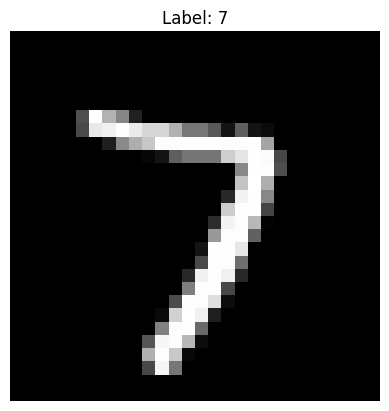

In [5]:
images, labels = next(iter(trainloader))
plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()


In [6]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [7]:
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
epochs = 1
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")


Epoch 1, Loss: 0.3882


In [9]:
torch.save(model.state_dict(), "mnist_simple_nn.pth")
print("Model saved.")


Model saved.


/tmp/ipykernel_41779/585012416.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("mnist_simple_nn.pth", map_location=device))


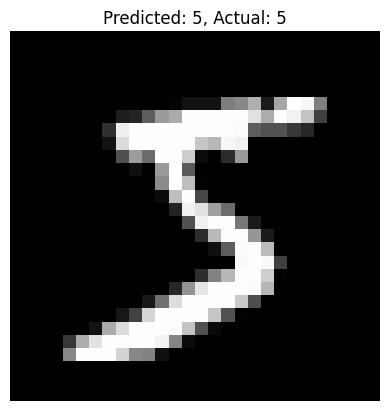

In [10]:
# Load model
loaded_model = SimpleNN().to(device)
loaded_model.load_state_dict(torch.load("mnist_simple_nn.pth", map_location=device))
loaded_model.eval()

# Run prediction
test_image, test_label = trainset[0]
with torch.no_grad():
    input_tensor = test_image.view(-1, 28 * 28).to(device)
    output = loaded_model(input_tensor)
    predicted_label = torch.argmax(output).item()

plt.imshow(test_image.squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_label}, Actual: {test_label}")
plt.axis('off')
plt.show()


In [13]:
# Recreate test_loader (if it’s not still in memory)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])

test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [14]:
# Evaluate accuracy on the full test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 89.53%
